In [1]:
import json
import os
import shutil
import tensorflow as tf
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  

In [2]:
# Define paths
PHOTOS_DIR = 'D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos' 
JSON_PATH = 'D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos.json'  
DRINKS_DIR = 'Drinks/'  # Output directory for processed drink images
IMAGE_SIZE = 64


In [3]:
if not os.path.exists(DRINKS_DIR):
    os.makedirs(DRINKS_DIR)
    print(f"Created directory: {DRINKS_DIR}")

Created directory: Drinks/


In [4]:
def load_photo_labels():
    import json
    import pandas as pd
    
    print("Loading photo labels from JSON...")
    
    # Read JSON lines file
    photo_data = []
    with open(JSON_PATH, 'r') as f:
        for line in f:
            photo_data.append(json.loads(line.strip()))
    
    # Convert to DataFrame
    df = pd.DataFrame(photo_data)
    
    # Filter for 'drink' label (not 'drinks')
    drinks_photos = df[df['label'] == 'drink']
    drink_ids = drinks_photos['photo_id'].tolist()
    
    # Limit to 3000 images
    limited_drink_ids = drink_ids[:5000]
    
    print(f"Selected {len(limited_drink_ids)} drink images from the dataset")
    return limited_drink_ids

In [5]:
def process_and_save_image(photo_id):
    try:
        original_path = os.path.join(PHOTOS_DIR, f'{photo_id}.jpg')
        processed_path = os.path.join(DRINKS_DIR, f'{photo_id}.jpg')
        
        if not os.path.exists(original_path):
            print(f"Warning: Image {photo_id} not found")
            return False
        
        img = Image.open(original_path)
        img = img.convert('L')  # Convert to grayscale
        img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.LANCZOS)
        img.save(processed_path)
        return True
    except Exception as e:
        print(f"Error processing image {photo_id}: {str(e)}")
    return False


In [6]:
def create_dataset():
    # Get list of drink photo IDs
    drink_photo_ids = load_photo_labels()
    
    if not drink_photo_ids:
        raise ValueError("No drink photos found in the JSON file!")
    
    # Process each drink photo with progress bar
    print("\nProcessing and saving drink images...")
    successful_processes = 0
    for photo_id in tqdm(drink_photo_ids):
        if process_and_save_image(photo_id):
            successful_processes += 1
    
    print(f"\nSuccessfully processed {successful_processes} out of {len(drink_photo_ids)} images")
    
    # Verify processed images
    processed_files = os.listdir(DRINKS_DIR)
    if not processed_files:
        raise ValueError("No images were processed successfully!")
    
    # Create TensorFlow dataset
    processed_image_paths = tf.data.Dataset.list_files(os.path.join(DRINKS_DIR, '*.jpg'))
    
    def load_and_preprocess_image(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=1)
        img = (tf.cast(img, tf.float32) - 127.5) / 127.5
        return img

    dataset = processed_image_paths.map(load_and_preprocess_image)
    dataset = dataset.shuffle(500)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [7]:
def display_sample_images():
    """
    Display a grid of 3x3 sample images from the processed dataset
    """
    print("Displaying sample processed images...")
    
    processed_images = os.listdir(DRINKS_DIR)
    if len(processed_images) < 9:
        print(f"Warning: Only {len(processed_images)} images available")
        num_images = min(9, len(processed_images))
    else:
        num_images = 9
    
    sample_images = np.random.choice(processed_images, num_images, replace=False)
    
    rows = (num_images + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(10, 10))
    axes = axes.flatten()
    
    for idx, img_name in enumerate(sample_images):
        img_path = os.path.join(DRINKS_DIR, img_name)
        img = Image.open(img_path)
        
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f'Image {idx+1}')
    
    # Turn off any unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_drinks.png')
    print("Sample images have been saved as 'sample_drinks.png'")


Loading photo labels from JSON...
Selected 5000 drink images from the dataset

Processing and saving drink images...


100%|██████████| 5000/5000 [00:20<00:00, 247.92it/s]



Successfully processed 5000 out of 5000 images
Displaying sample processed images...
Sample images have been saved as 'sample_drinks.png'


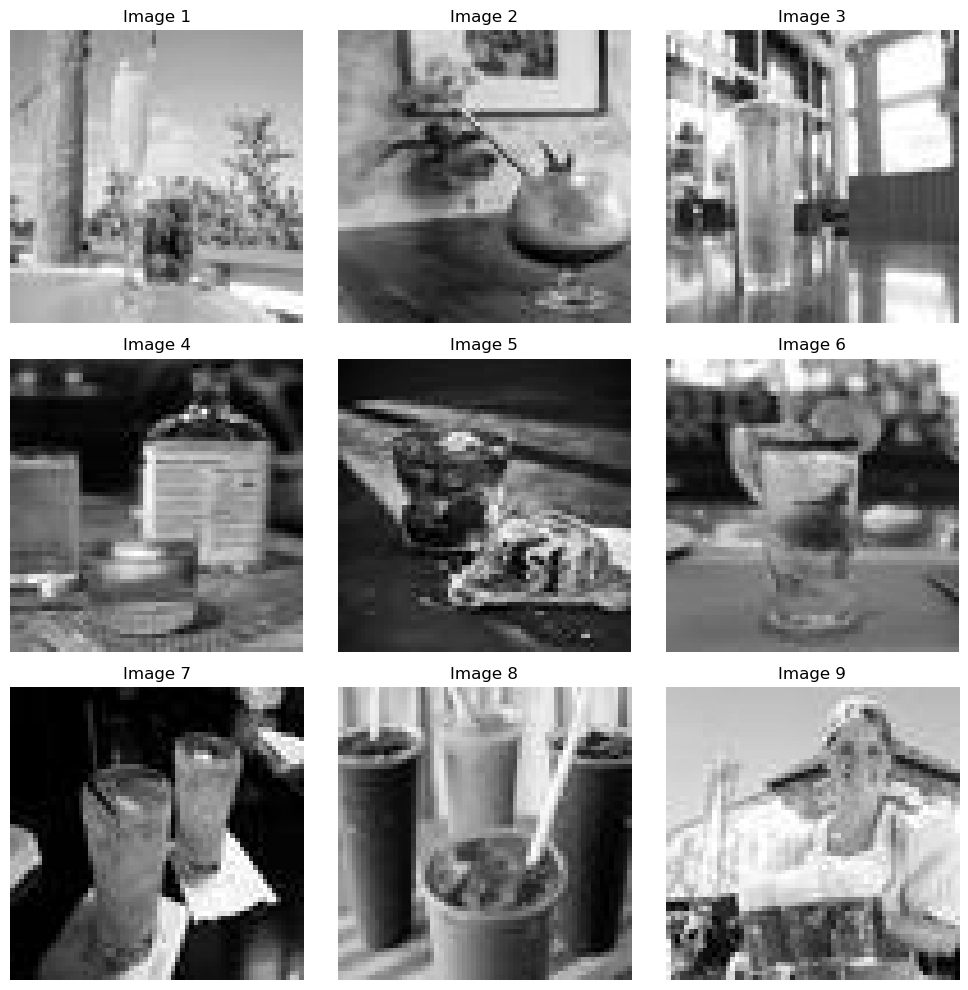

In [8]:
# Create the dataset and display samples
train_dataset = create_dataset()
display_sample_images()

Displaying sample processed images...
Sample images have been saved as 'sample_drinks.png'

Final Dataset Statistics:
- Image Size: 64x64
- Batch Size: 32
- Total processed images: 5000


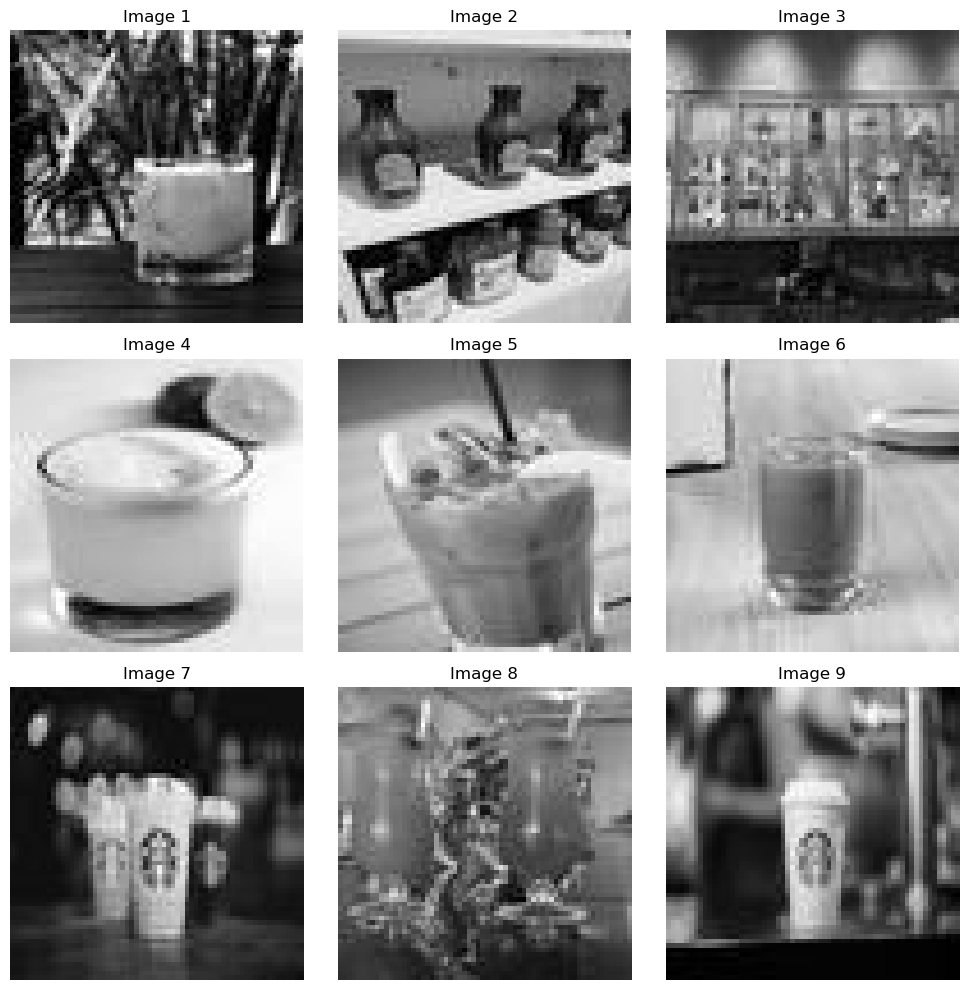

In [9]:
# Display sample images
display_sample_images()

# Print final statistics
print("\nFinal Dataset Statistics:")
print(f"- Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"- Batch Size: 32")
print(f"- Total processed images: {len(os.listdir(DRINKS_DIR))}")

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [11]:
# Constants
LATENT_DIM = 100
IMAGE_SIZE = 64
CHANNELS = 1
GENERATOR_FILTERS = 64
DISCRIMINATOR_FILTERS = 64

In [12]:
def create_generator_block(x, filters, kernel_size, strides):
    """Creates a generator block with upsampling"""
    x = layers.Conv2DTranspose(
        filters, kernel_size, 
        strides=strides, 
        padding='same',
        use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


In [13]:
def build_generator():
    """Builds the generator model for 64x64 images"""
    # Input layer
    noise_input = layers.Input(shape=(LATENT_DIM,))
    
    # Initial dense layer and reshape
    x = layers.Dense(4 * 4 * GENERATOR_FILTERS * 8, use_bias=False)(noise_input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Reshape((4, 4, GENERATOR_FILTERS * 8))(x)
    
    # Upsampling blocks
    # 4x4 -> 8x8
    x = create_generator_block(x, GENERATOR_FILTERS * 4, 5, 2)
    # 8x8 -> 16x16
    x = create_generator_block(x, GENERATOR_FILTERS * 2, 5, 2)
    # 16x16 -> 32x32
    x = create_generator_block(x, GENERATOR_FILTERS, 5, 2)
    # 32x32 -> 64x64
    x = layers.Conv2DTranspose(
        CHANNELS, 5, 
        strides=2, 
        padding='same',
        use_bias=False,
        activation='tanh'
    )(x)
    
    return models.Model(noise_input, x, name='generator')


In [14]:
def create_discriminator_block(x, filters, kernel_size, strides):
    """Creates a discriminator block with downsampling"""
    x = layers.Conv2D(
        filters, kernel_size,
        strides=strides,
        padding='same'
    )(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    return x

In [15]:
def build_discriminator():
    """Builds the discriminator model for 64x64 images"""
    # Input layer
    img_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    
    # Downsampling blocks
    # 64x64 -> 32x32
    x = create_discriminator_block(img_input, DISCRIMINATOR_FILTERS, 5, 2)
    # 32x32 -> 16x16
    x = create_discriminator_block(x, DISCRIMINATOR_FILTERS * 2, 5, 2)
    # 16x16 -> 8x8
    x = create_discriminator_block(x, DISCRIMINATOR_FILTERS * 4, 5, 2)
    # 8x8 -> 4x4
    x = create_discriminator_block(x, DISCRIMINATOR_FILTERS * 8, 5, 2)
    
    # Flatten and output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(img_input, x, name='discriminator')


In [16]:
def create_gan(generator, discriminator):
    """Combines generator and discriminator into GAN model"""
    discriminator.trainable = False
    gan_input = layers.Input(shape=(LATENT_DIM,))
    gan_output = discriminator(generator(gan_input))
    return models.Model(gan_input, gan_output, name='dcgan')


In [17]:
def get_optimizers():
    """Returns optimizers for generator and discriminator"""
    return (
        Adam(learning_rate=0.0002, beta_1=0.5),  # Generator optimizer
        Adam(learning_rate=0.0002, beta_1=0.5)   # Discriminator optimizer
    )


In [18]:
def generate_latent_points(batch_size):
    """Generate points in latent space as input for the generator"""
    return tf.random.normal([batch_size, LATENT_DIM])


In [19]:
def generate_fake_samples(generator, batch_size):
    """Generate fake images using the generator"""
    latent_points = generate_latent_points(batch_size)
    fake_images = generator(latent_points, training=False)
    return fake_images

In [20]:
def generator_loss(fake_output):
    """Calculate generator loss"""
    return tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(
            tf.ones_like(fake_output), fake_output
        )
    )

def discriminator_loss(real_output, fake_output):
    """Calculate discriminator loss"""
    real_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(
            tf.ones_like(real_output), real_output
        )
    )
    fake_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(
            tf.zeros_like(fake_output), fake_output
        )
    )
    return real_loss + fake_loss

In [21]:
def train_step(generator, discriminator, gan_model, batch_images, batch_size,
                generator_optimizer, discriminator_optimizer):
    """Performs a single training step"""
    # Generate latent points
    latent_points = generate_latent_points(batch_size)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(latent_points, training=True)
        
        # Get discriminator predictions
        real_output = discriminator(batch_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # Calculate gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients
    generator_optimizer.apply_gradients(
        zip(gen_gradients, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(disc_gradients, discriminator.trainable_variables)
    )
    
    return gen_loss, disc_loss


### Key functions:

- build_generator(): Creates the generator network
- build_discriminator(): Creates the discriminator network
- create_gan(): Combines both networks
- train_step(): Handles single training iteration
- functions for loss calculation and sample generation

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [23]:
# Training Parameters
BATCH_SIZE = 32  # Smaller batch size for laptop GPU
EPOCHS = 30
SAVE_INTERVAL = 10
NOISE_DIM = 100

In [24]:
def generate_random_noise(batch_size, noise_dim):
    """Generate random noise vectors"""
    return tf.random.normal([batch_size, noise_dim])

In [25]:
def save_generated_images(generator, epoch, noise_samples=16):
    """Save a grid of generated images"""
    noise = generate_random_noise(noise_samples, NOISE_DIM)
    generated_images = generator(noise, training=False)
    
    # Rescale images from [-1, 1] to [0, 1]
    generated_images = (generated_images + 1) / 2.0
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(noise_samples):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # Save the plot
    output_dir = 'generated_images'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(f'{output_dir}/epoch_{epoch}.png')
    plt.close()


In [26]:
def plot_training_history(gen_losses, disc_losses):
    """Plot the training history"""
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_history.png')
    plt.close()

# Memory management functions
def clear_gpu_memory():
    """Clear GPU memory between training sessions"""
    tf.keras.backend.clear_session()

In [27]:
def train_dcgan(dataset, generator, discriminator, epochs=EPOCHS):
    """Main training loop for DCGAN"""
    
    # Initialize optimizers
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
    
    # Lists to store loss values
    gen_losses = []
    disc_losses = []
    
    # Checkpoint setup
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(
        generator_optimizer=generator_optimizer,
        discriminator_optimizer=discriminator_optimizer,
        generator=generator,
        discriminator=discriminator
    )

    @tf.function  # Use tf.function for better performance
    def train_step(real_images):
        """Single training step"""
        batch_size = tf.shape(real_images)[0]
        noise = generate_random_noise(batch_size, NOISE_DIM)
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate fake images
            generated_images = generator(noise, training=True)
            
            # Get discriminator predictions
            real_output = discriminator(real_images, training=True)
            fake_output = discriminator(generated_images, training=True)
            
            # Calculate losses
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
        
        # Calculate gradients
        gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # Apply gradients
        generator_optimizer.apply_gradients(
            zip(gen_gradients, generator.trainable_variables)
        )
        discriminator_optimizer.apply_gradients(
            zip(disc_gradients, discriminator.trainable_variables)
        )
        
        return gen_loss, disc_loss

    def train_epoch(epoch):
        """Training for one epoch"""
        start = time.time()
        total_gen_loss = 0
        total_disc_loss = 0
        steps = 0
        
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            steps += 1
            
            # Print progress
            if steps % 10 == 0:
                print(f'Epoch {epoch+1}, Step {steps}: '
                      f'Gen Loss = {gen_loss:.4f}, '
                      f'Disc Loss = {disc_loss:.4f}')
        
        # Calculate average losses for the epoch
        avg_gen_loss = total_gen_loss / steps
        avg_disc_loss = total_disc_loss / steps
        
        # Save losses for plotting
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)
        
        print(f'Epoch {epoch+1}: '
              f'Time = {time.time()-start:.2f}s, '
              f'Gen Loss = {avg_gen_loss:.4f}, '
              f'Disc Loss = {avg_disc_loss:.4f}')
        
        # Save generated images
        if (epoch + 1) % SAVE_INTERVAL == 0:
            save_generated_images(generator, epoch + 1)
            # Save checkpoint
            checkpoint.save(file_prefix=checkpoint_prefix)

    # Main training loop
    try:
        for epoch in range(epochs):
            train_epoch(epoch)
    except KeyboardInterrupt:
        print("Training interrupted by user")
    
    # Save final model and plot training history
    plot_training_history(gen_losses, disc_losses)
    return gen_losses, disc_losses

In [28]:
# Configure GPU
#configure_gpu()
# Build models (from previous step)
generator = build_generator()
discriminator = build_discriminator()

# Train the model
gen_losses, disc_losses = train_dcgan(train_dataset, generator, discriminator)

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1, Step 10: Gen Loss = 0.5962, Disc Loss = 1.2055
Epoch 1, Step 20: Gen Loss = 1.9528, Disc Loss = 0.2468
Epoch 1, Step 30: Gen Loss = 3.0043, Disc Loss = 0.1070
Epoch 1, Step 40: Gen Loss = 4.4448, Disc Loss = 0.1685
Epoch 1, Step 50: Gen Loss = 5.6567, Disc Loss = 0.0434
Epoch 1, Step 60: Gen Loss = 4.7809, Disc Loss = 0.0686
Epoch 1, Step 70: Gen Loss = 7.7525, Disc Loss = 0.0007
Epoch 1, Step 80: Gen Loss = 4.7977, Disc Loss = 0.0444
Epoch 1, Step 90: Gen Loss = 6.1723, Disc Loss = 0.0059
Epoch 1, Step 100: Gen Loss = 6.8411, Disc Loss = 0.1174
Epoch 1, Step 110: Gen Loss = 6.5918, Disc Loss = 0.0032
Epoch 1, Step 120: Gen Loss = 10.5651, Disc Loss = 0.0007
Epoch 1, Step 130: Gen Loss = 7.3397, Disc Loss = 0.0038
Epoch 1, Step 140: Gen Loss = 9.6041, Disc Loss = 0.0046
Epoch 1, Step 150: Gen Loss = 7.1318, Disc Loss = 0.0051
Epoch 1: Time = 76.69s, Gen Loss = 5.1384, Disc Loss = 0.1782
Epoch 2, Step 10: Gen Loss = 5.1727, Disc Loss = 0.0151
Epoch 2, Step 20: Gen Loss = 8.4257

In [29]:
def generate_and_save_images(generator, num_images=5, output_dir='generated_images'):
    """
    Generate and save images using the trained generator
    
    Args:
        generator: Trained generator model
        num_images: Number of images to generate
        output_dir: Directory to save the generated images
    """
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Generate random noise vectors
    noise = tf.random.normal([num_images, LATENT_DIM])
    
    # Generate images
    generated_images = generator(noise, training=False)
    
    # Rescale images from [-1, 1] to [0, 1]
    generated_images = (generated_images + 1) / 2.0
    
    # Plot and save each image
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
        
        # Save individual image
        plt.imsave(
            os.path.join(output_dir, f'generated_image_{i+1}.png'),
            generated_images[i, :, :, 0],
            cmap='gray'
        )
    
    # Save the grid of images
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'generated_grid.png'))
    plt.close()
    
    print(f"Generated {num_images} images and saved them in '{output_dir}'")
    return generated_images

In [30]:
def quality_check(generated_images):
    """
    Perform basic quality checks on generated images
    
    Args:
        generated_images: Tensor of generated images
    """
    # Check image statistics
    print("\nImage Quality Metrics:")
    print(f"Shape: {generated_images.shape}")
    print(f"Min value: {tf.reduce_min(generated_images):.3f}")
    print(f"Max value: {tf.reduce_max(generated_images):.3f}")
    print(f"Mean value: {tf.reduce_mean(generated_images):.3f}")
    print(f"Standard deviation: {tf.math.reduce_std(generated_images):.3f}")
    
    # Check for any  values
    if tf.reduce_any(tf.math.is_nan(generated_images)):
        print("Warning: Generated images contain  values!")
    
    # Check for low variance (which might indicate mode collapse)
    variance = tf.math.reduce_variance(generated_images)
    if variance < 0.01:
        print("Warning: Low variance in generated images might indicate mode collapse!")
    else:
        print(f"Variance looks good: {variance:.3f}")

In [31]:
# Generate and save images
generated_images = generate_and_save_images(generator, num_images=5)

# Perform quality check
quality_check(generated_images)

Generated 5 images and saved them in 'generated_images'

Image Quality Metrics:
Shape: (5, 64, 64, 1)
Min value: 0.000
Max value: 1.000
Mean value: 0.357
Standard deviation: 0.386
Variance looks good: 0.149
